In [1]:
from scripts.pipeline_tools import (
    classifier_accuracy,
    prepare_data,
    regressor_uncertainty,
    select_unstable_data,
    retrain_regressor,
    plot_scatter,
    uncertainty_change
)
from scripts.Models import ITGDatasetDF, load_model, ITGDataset
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from scripts.utils import train_keys
import copy
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
pretrained = {
    "ITG_class": {
        "trained": True,
        # "save_path": "/home/tmadula/UKAEAGroupProject/src/notebooks/classifier_model.pt",
        # "save_path": "/unix/atlastracking/jbarr/UKAEAGroupProject/src/notebooks/classifier_model.pt",
        "save_path": "/Users/thandikiremadula/Desktop/UKAEA_data/classifier_model.pt"
    },
    "ITG_reg": {
        "trained": True,
        # "save_path": "/home/tmadula/UKAEAGroupProject/src/notebooks/regression_model.pt",
        # "save_path": "/unix/atlastracking/jbarr/UKAEAGroupProject/src/notebooks/regression_model.pt",
        "save_path": "/Users/thandikiremadula/Desktop/UKAEA_data/regression_model.pt"
    },
}

# Data loading

# TRAIN_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
# TRAIN_PATH = "/unix/atlastracking/jbarr/train_data_clipped.pkl"
TRAIN_PATH = "/Users/thandikiremadula/Desktop/UKAEA_data/train_data_clipped.pkl"

# VALIDATION_PATH = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
# VALIDATION_PATH = "/unix/atlastracking/jbarr/valid_data_clipped.pkl"
VALIDATION_PATH = "/Users/thandikiremadula/Desktop/UKAEA_data/valid_data_clipped.pkl"

In [3]:
train_data, val_data = prepare_data(
    TRAIN_PATH, VALIDATION_PATH, target_column="efiitg_gb", target_var="itg"
)

scaler = StandardScaler()
scaler.fit_transform(train_data.drop(["itg"], axis=1))

train_dataset = ITGDatasetDF(train_data, target_column="efiitg_gb", target_var="itg")
valid_dataset = ITGDatasetDF(val_data, target_column="efiitg_gb", target_var="itg")

# # TODO: further testing of the scale function
train_dataset.scale(scaler)
valid_dataset.scale(scaler)

In [4]:
# Load pretrained models
models = {}
for model in pretrained:
    if pretrained[model]["trained"] == True:
        trained_model = load_model(model, pretrained[model]["save_path"])
        models[model] = trained_model
print("Loaded the following models:\n")
for model_name in models:
    print(f"Model: {model_name}\n")
    # print(models[model_name])

ITG_class
ITG_reg
Loaded the following models:

Model: ITG_class

Model: ITG_reg



In [5]:
# TODO: Needs to be the true training samples used!!!
train_sample = train_dataset.sample(10_000)
valid_sample = valid_dataset.sample(10_000)


# remove the sampled data points from the dataset
valid_dataset.remove(valid_sample.data.index)

In [6]:
select_unstable_data(valid_sample, batch_size=100, classifier=models["ITG_class"])


Running classifier selection...



100%|██████████| 100/100 [00:03<00:00, 26.34it/s]


Stable points: 7468
Misclassified points: 650
Percentage of misclassified points:  6.5%

Dropped 7684 rows


In [7]:
uncertain_datset, uncert_before, data_idx = regressor_uncertainty(
    valid_sample, models["ITG_reg"], n_runs=15, keep=0.25
)

train_sample.add(uncertain_datset)

uncertain_loader = DataLoader(train_sample, batch_size=len(train_sample), shuffle=True)


Running MC Dropout....



100%|██████████| 15/15 [00:19<00:00,  1.30s/it]



Number of points passed for MC dropout: 2316


In [8]:
prediction_before, prediction_idx_order = models["ITG_reg"].predict(uncertain_loader)

In [9]:
# Switching validation dataset to numpy arrays to see if it is quicker
x_array = valid_dataset.data[train_keys].values
y_array = valid_dataset.data["itg"].values
z_array = valid_dataset.data["efiitg_gb"].values
dataset_numpy = ITGDataset(x_array, y_array, z_array)
valid_loader = DataLoader(
    dataset_numpy, batch_size=int(0.1 * len(y_array)), shuffle=True
)

In [10]:
# Retrain Regressor (Further research required)
retrain_regressor(
    uncertain_loader,
    valid_loader,
    models["ITG_reg"],
    learning_rate=1e-3,
    epochs=20,
    validation_step=True,
    mode="warm_start",
)


Retraining regressor...

Training on 10579 points


100%|██████████| 11/11 [00:15<00:00,  1.41s/it]


Initial loss: 0.7401
Train Step:  0
Loss: 1.1762
Validation Step:  0


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]


Test loss: 0.6682
Train Step:  1
Loss: 1.0512
Train Step:  2
Loss: 0.9473
Train Step:  3
Loss: 0.8681
Train Step:  4
Loss: 0.8076
Train Step:  5
Loss: 0.7674
Train Step:  6
Loss: 0.7341
Train Step:  7
Loss: 0.7004
Train Step:  8
Loss: 0.6609
Train Step:  9
Loss: 0.6127
Train Step:  10
Loss: 0.5735
Validation Step:  10


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


Test loss: 0.3917
Train Step:  11
Loss: 0.5270
Train Step:  12
Loss: 0.4960
Train Step:  13
Loss: 0.4800
Train Step:  14
Loss: 0.4615
Train Step:  15
Loss: 0.4519
Train Step:  16
Loss: 0.4279
Train Step:  17
Loss: 0.4088
Train Step:  18
Loss: 0.3816
Train Step:  19
Loss: 0.3718


In [11]:
prediction_after,_ = models["ITG_reg"].predict(uncertain_loader, prediction_idx_order)

In [12]:
_, uncert_after,_ = regressor_uncertainty(valid_sample, models["ITG_reg"], n_runs=15, keep=0.25, order_idx=data_idx)


Running MC Dropout....



100%|██████████| 15/15 [00:19<00:00,  1.27s/it]



Number of points passed for MC dropout: 2316


 Decreased 98.618% Increased: 1.382 % No Change: 0.000 


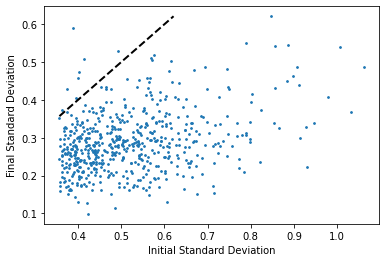

In [13]:
uncertainty_change(x=uncert_before, y=uncert_after);

### Section to be modularised

In [14]:
def get_mse(y_hat, y): 
    mse = np.mean((y-y_hat)**2)
    return mse


In [15]:
idxs = prediction_idx_order.astype(int)
ground_truth = uncertain_loader.dataset.data.loc[idxs]
ground_truth = ground_truth['efiitg_gb']
ground_truth = ground_truth.to_numpy()

In [16]:
mse_before = get_mse(prediction_before, ground_truth)
mse_after = get_mse(prediction_after, ground_truth)
delta_mse = mse_after - mse_before

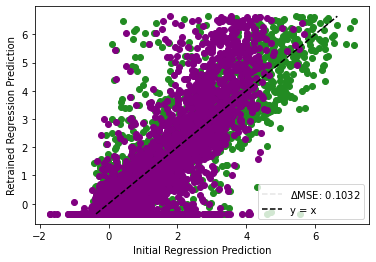

In [17]:
x_min = ground_truth.min()
x_max = ground_truth.max()
plt.figure()
plt.scatter(prediction_before, ground_truth, c='forestgreen')
plt.scatter(prediction_after, ground_truth, c='purple')
plt.plot(
    np.linspace(x_min, x_max, 50),
    np.linspace(x_min, x_max, 50),
    ls='--',
    c='black',
    label = f'$\Delta$MSE: {delta_mse:.4f}',
    alpha = 0.1
    )
plt.plot(
    np.linspace(x_min, x_max, 50),
    np.linspace(x_min, x_max, 50),
    ls='--',
    c='black',
    label = 'y = x'
    )
plt.xlabel("Initial Regression Prediction")
plt.ylabel("Retrained Regression Prediction")
plt.legend()

#### Change in Training Data Regression Quality and Uncertainties